In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
from contextlib import contextmanager
import gc
from collections import Counter

import re

from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [3]:
def pca(X, y):
    pca = PCA(n_components=2)
    X = pca.fit_transform(X)
    plot_2d_space(X, y, 'dataset (2 PCA components)')

# 2-dimensional plot function, plot_2d_space, to see the data distribution:           
def plot_2d_space(X, y, label='Classes'):   
    # Data display
    colors = ['#00FF00', '#FF0000']
    for l, c in zip(np.unique(y), colors):
        plt.scatter(X[y == l, 0],
                    X[y == l, 1],
                    c=c, label=l)
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [4]:
# Importation des jeux de données
path = '../Données/'

train_df = pd.read_csv(path + 'application_train.csv')
print('"Application Train" shape :', train_df.shape)
df_bureau = pd.read_csv(path + 'bureau.csv')
print('"Bureau" shape :', df_bureau.shape)
df_bureau_balance = pd.read_csv(path + 'bureau_balance.csv')
print('"Bureau Balance" shape :', df_bureau_balance.shape)
df_previous = pd.read_csv(path + 'previous_application.csv')
print('"Previous Application" shape :', df_previous.shape)
df_pos_cash = pd.read_csv(path + 'POS_CASH_balance.csv')
print('"POS_CASH Balance" shape :', df_pos_cash.shape)
df_installments = pd.read_csv(path + 'installments_payments.csv')
print('"Installments Payments" shape :', df_installments.shape)
df_credit_card = pd.read_csv(path + 'credit_card_balance.csv')
print('"Credit Card Balance" shape :', df_credit_card.shape)

"Application Train" shape : (307511, 122)
"Bureau" shape : (1716428, 17)
"Bureau Balance" shape : (27299925, 3)
"Previous Application" shape : (1670214, 37)
"POS_CASH Balance" shape : (10001358, 8)
"Installments Payments" shape : (13605401, 8)
"Credit Card Balance" shape : (3840312, 23)


In [5]:
# Preprocess application_train.csv
with timer("Process application_train"):
    nan_as_category = False
    df_applications = train_df
    print('"Application_Train" shape:', df_applications.shape)
    del train_df    
    
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    # df_applications = df_applications[df_applications['CODE_GENDER'] != 'XNA']
    df_applications = df_applications[df_applications['CODE_GENDER'] != 'XNA']
   
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df_applications[bin_feature], uniques = pd.factorize(df_applications[bin_feature])

    # Categorical features with One-Hot encode
    df_applications, cat_cols = one_hot_encoder(df_applications, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df_applications = df_applications[df_applications['DAYS_EMPLOYED']!= 365243]
    
    # Some simple new features (percentages)
    df_applications['DAYS_EMPLOYED_PERC'] = df_applications['DAYS_EMPLOYED'] / df_applications['DAYS_BIRTH']
    df_applications['INCOME_CREDIT_PERC'] = df_applications['AMT_INCOME_TOTAL'] / df_applications['AMT_CREDIT']
    df_applications['INCOME_PER_PERSON'] = df_applications['AMT_INCOME_TOTAL'] / df_applications['CNT_FAM_MEMBERS']
    df_applications['ANNUITY_INCOME_PERC'] = df_applications['AMT_ANNUITY'] / df_applications['AMT_INCOME_TOTAL']
    df_applications['PAYMENT_RATE'] = df_applications['AMT_ANNUITY'] / df_applications['AMT_CREDIT']
    print('"Application_Train" final shape:', df_applications.shape)

"Application_Train" shape: (307511, 122)
"Application_Train" final shape: (252133, 247)
Process application_train - done in 2s


In [6]:
# Preprocess bureau.csv and bureau_balance.csv
with timer("Process bureau and bureau_balance"):
    nan_as_category = True
    print('"Bureau" shape:', df_bureau.shape)
    print('"Bureau Balance" shape:', df_bureau_balance.shape)

    df_bureau_balance, bb_cat = one_hot_encoder(df_bureau_balance, nan_as_category)
    df_bureau, bureau_cat = one_hot_encoder(df_bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size', 'mean']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    # Status of Credit Bureau loan during the month
    bb_agg = df_bureau_balance.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    df_bureau = df_bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    del df_bureau_balance, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }

    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    df_bureau_agg = df_bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    df_bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in df_bureau_agg.columns.tolist()])
    del  bureau_cat, bb_cat

    # Bureau: Active credits - using only numerical aggregations
    active = df_bureau[df_bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    df_bureau_agg = df_bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()

    # Bureau: Closed credits - using only numerical aggregations
    closed = df_bureau[df_bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    df_bureau_agg = df_bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, df_bureau
    gc.collect()

    print('"Bureau/Bureau Balance" final shape:', df_bureau_agg.shape)

"Bureau" shape: (1716428, 17)
"Bureau Balance" shape: (27299925, 3)
"Bureau/Bureau Balance" final shape: (305811, 116)
Process bureau and bureau_balance - done in 16s


In [7]:
# Preprocess previous_applications.csv
with timer("Process previous_applications"):
    nan_as_category = True
    print('"Previous applications" shape:', df_previous.shape)
    df_previous, cat_cols = one_hot_encoder(df_previous, nan_as_category=True)

    # Days 365.243 values -> nan
    df_previous = df_previous[df_previous['DAYS_FIRST_DRAWING'] != 365243]
    df_previous = df_previous[df_previous['DAYS_FIRST_DUE'] != 365243]
    df_previous = df_previous[df_previous['DAYS_LAST_DUE_1ST_VERSION'] != 365243]
    df_previous = df_previous[df_previous['DAYS_LAST_DUE'] != 365243]
    df_previous = df_previous[df_previous['DAYS_TERMINATION'] != 365243]
    
    # Add feature: value ask / value received percentage
    df_previous['APP_CREDIT_PERC'] = df_previous['AMT_APPLICATION'] / df_previous['AMT_CREDIT']  

    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }

    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    df_previous_agg = df_previous.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    df_previous_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in df_previous_agg.columns.tolist()])

    # Previous Applications: Approved Applications - only numerical features
    approved = df_previous[df_previous['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    df_previous_agg = df_previous_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    del approved, approved_agg
    gc.collect()
    
    # Previous Applications: Refused Applications - only numerical features
    refused = df_previous[df_previous['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    df_previous_agg = df_previous_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del df_previous, refused, refused_agg
    gc.collect()

    print('"Previous applications" final shape:', df_previous_agg.shape)

"Previous applications" shape: (1670214, 37)
"Previous applications" final shape: (201759, 249)
Process previous_applications - done in 13s


In [8]:
with timer("Process POS-CASH balance"):
    nan_as_category = True
    print('"Pos-Cash" shape:', df_pos_cash.shape) 
    df_pos_cash, cat_cols = one_hot_encoder(df_pos_cash, nan_as_category=True)

    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }

    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = df_pos_cash.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

    # Count pos cash accounts
    pos_agg['POS_COUNT'] = df_pos_cash.groupby('SK_ID_CURR').size()
    del df_pos_cash
    gc.collect()

    print('"Pos-Cash" final shape:', pos_agg.shape) 

"Pos-Cash" shape: (10001358, 8)
"Pos-Cash" final shape: (337252, 18)
Process POS-CASH balance - done in 7s


In [9]:
# Preprocess installments_payments.csv
with timer("Process installments payments"):
    nan_as_category = True
    print('"Installments Payments" shape:', df_installments.shape)
    df_installments, cat_cols = one_hot_encoder(df_installments, nan_as_category=True)

    # Percentage and difference paid in each installment (amount paid and installment value)
    df_installments['PAYMENT_PERC'] = df_installments['AMT_PAYMENT'] / df_installments['AMT_INSTALMENT']
    df_installments['PAYMENT_DIFF'] = df_installments['AMT_INSTALMENT'] - df_installments['AMT_PAYMENT']

    # Days past due and days before due (no negative values)
    df_installments['DPD'] = df_installments['DAYS_ENTRY_PAYMENT'] - df_installments['DAYS_INSTALMENT']
    df_installments['DBD'] = df_installments['DAYS_INSTALMENT'] - df_installments['DAYS_ENTRY_PAYMENT']
    df_installments['DPD'] = df_installments['DPD'].apply(lambda x: x if x > 0 else 0)
    df_installments['DBD'] = df_installments['DBD'].apply(lambda x: x if x > 0 else 0)

    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }

    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = df_installments.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = df_installments.groupby('SK_ID_CURR').size()

    del df_installments
    gc.collect()

    print('"Installments Payments" final shape:', ins_agg.shape)

"Installments Payments" shape: (13605401, 8)
"Installments Payments" final shape: (339587, 26)
Process installments payments - done in 27s


In [10]:
# Preprocess credit_card_balance.csv
with timer("Process credit card balance"):
    nan_as_category = True
    print('"Credit Card Balance" shape:', df_credit_card.shape)
    df_credit_card, cat_cols = one_hot_encoder(df_credit_card, nan_as_category=True)

    # General aggregations
    df_credit_card.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = df_credit_card.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

    # Count credit card lines
    cc_agg['CC_COUNT'] = df_credit_card.groupby('SK_ID_CURR').size()

    del df_credit_card
    gc.collect()

    print('"Credit Card Balance" final shape:', cc_agg.shape)

"Credit Card Balance" shape: (3840312, 23)
"Credit Card Balance" final shape: (103558, 141)
Process credit card balance - done in 11s


In [11]:
df = df_applications.join(df_bureau_agg, how='left', on='SK_ID_CURR')
del df_applications, df_bureau_agg
print(df.shape)

df = df.join(df_previous_agg, how='left', on='SK_ID_CURR')
del df_previous_agg

df = df.join(pos_agg, how='left', on='SK_ID_CURR')
del pos_agg

df = df.join(ins_agg, how='left', on='SK_ID_CURR')
del ins_agg

df = df.join(cc_agg, how='left', on='SK_ID_CURR')
del cc_agg

print('Final shape:', df.shape)

(252133, 363)
Final shape: (252133, 797)


In [12]:
#Replace infinity values by NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [13]:
# Save preprocessed df to a file
df.to_csv('df_preprocessed.csv', index=False)

### Traitement des valeurs manquantes

In [14]:
# Function to calculate missing values by column 
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
        
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
        
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) +
          " columns. There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values")
        
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [15]:
print("Removing empty columns > 50% :")
print("=============================")
# removing empty columns > 50%
df = df.loc[:, df.isnull().mean() < .50]
print("Done : 100%")
    
missing_values_table(df)

Removing empty columns > 50% :
Done : 100%
Your selected dataframe has 517 columns. There are 334 columns that have missing values


,Missing Values,% of Total Values
LIVINGAREA_MEDI,125912,49.9
LIVINGAREA_MODE,125912,49.9
LIVINGAREA_AVG,125912,49.9
FLOORSMAX_AVG,124856,49.5
FLOORSMAX_MEDI,124856,49.5
...,...,...
PAYMENT_RATE,12,0.0
AMT_ANNUITY,12,0.0
INCOME_PER_PERSON,2,0.0
CNT_FAM_MEMBERS,2,0.0


In [16]:
df.shape

(252133, 517)

### Affichage déséquilibre des classes

In [17]:
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y = df['TARGET']
X_id = df['SK_ID_CURR']

X = df.drop(['TARGET', 'SK_ID_CURR'], axis=1)

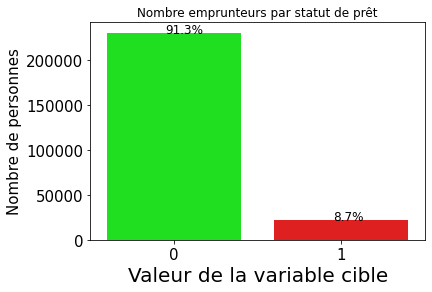

In [18]:
def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size=12)
    plt.show()


fig = plt.figure()
pal = {c: 'lime' if c != 1 else 'r' for c in df['TARGET'].unique()}
ax = sns.barplot(x=df['TARGET'].value_counts().index,
                 y=df['TARGET'].value_counts().values,
                 palette=pal)
plt.title('Nombre emprunteurs par statut de prêt')
plt.xlabel('Valeur de la variable cible', fontsize=20)
plt.ylabel('Nombre de personnes', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

without_hue(ax, df['TARGET'])

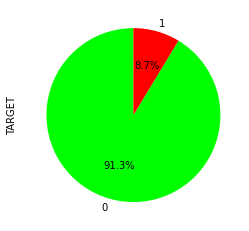

In [19]:
fig = plt.figure()
ax = plt.axes()
colors=['lime', 'r']
y.value_counts().plot.pie(startangle=90, autopct='%1.1f%%', colors=colors)
plt.show()

In [20]:
# Save final df to a file
df.to_csv('df_final.csv', index=False)